In [1]:
# Workbook analysing the movement pattern of 181 users whose data were collected over a period of three years.

import skmob
import geopandas as gpd
from skmob.preprocessing import detection, clustering, compression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skmob.tessellation import tilers

In [2]:
# Import the data
df = pd.read_csv('newGeolife.csv')

In [3]:
# Remove the unnamed column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# use skmob to read the loaded dataframe
tdf = skmob.TrajDataFrame(df, latitude='lat', longitude='lng', datetime = 'datetime')

In [5]:
# Remove points that falls outside the boundary of the study-site
tdf=tdf[(tdf['lat']<40.35) & (tdf['lat']>39.7)]
tdf=tdf[(tdf['lng']<116.8) & (tdf['lng']>116)]

In [5]:
# Display a map showing the movement pattern of two of the users
map_f = tdf.plot_trajectory(max_users=2, start_end_markers=False)
map_f

/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/skmob/utils/plot.py:133: UserWarning: Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  warnings.warn("Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.")
/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/skmob/utils/plot.py:158: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, sepecify `max_points=None`.
  warnings.warn("If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, sepecify `max_points=None`.")


In [6]:
#stop detection
# create stops where a user spent more than 20 minutes. These locations could be schools, shops, offices, filling stations e.t.c
stdf = detection.stops(tdf, stop_radius_factor=0.5, minutes_for_a_stop=20.0, spatial_radius_km=0.5, leaving_time=True)

# Cluster together the stop points that are close to each other
cstdf = clustering.cluster(stdf)

# Plot these stops
cstdf.plot_stops(max_users=1, map_f=map_f)

/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/skmob/utils/plot.py:319: UserWarning: Only the stops of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  warnings.warn("Only the stops of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.")


In [7]:
# creating these stops leads to the creation of another column named leaving_datetime
cstdf.head()

lat         lng            datetime uid    leaving_datetime  cluster
0  39.983680  116.299314 2008-10-23 03:01:55   0 2008-10-23 04:08:07      135
1  39.999665  116.324504 2008-10-23 04:32:47   0 2008-10-23 09:42:25        0
2  40.008716  116.321419 2008-10-23 09:52:30   0 2008-10-26 13:44:12        1
3  39.926514  116.320361 2008-10-26 15:03:37   0 2008-10-27 11:54:52      134
4  40.008768  116.322512 2008-10-27 12:03:59   0 2008-10-28 00:38:31        1

In [9]:
# creating a list of all the all the users
users_id=list(set(tdf.uid))

<AxesSubplot:title={'center':'user 21'}>

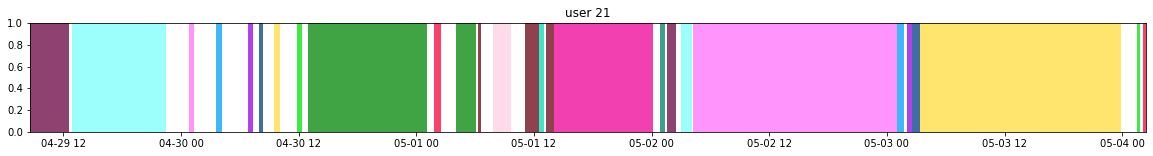

In [10]:
# Plot a users movement.
# The longer the width of the box, the longer the user stayed in that location
cstdf.plot_diary(users_id[0])

<AxesSubplot:title={'center':'user 99'}>

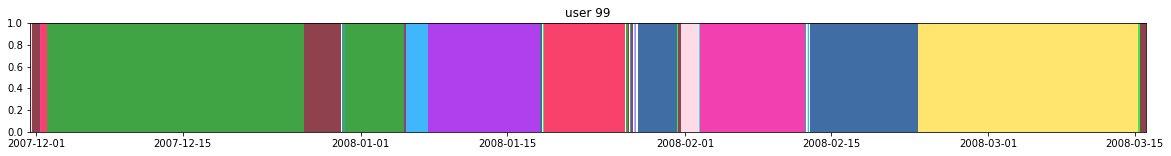

In [11]:
cstdf.plot_diary(users_id[1])

In [13]:
# group the Clustered stops by the cluster and user ID
centroid_clusters=cstdf.groupby(['uid','cluster']).mean().reset_index()

(116.0, 116.8)

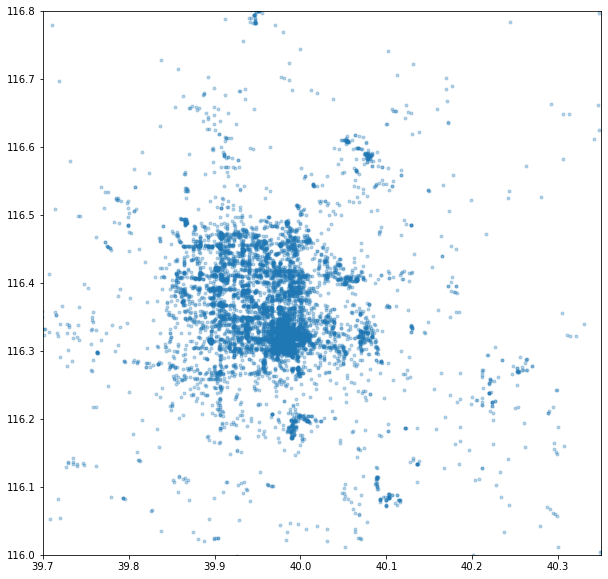

In [14]:
plt.figure(figsize=(10,10))
plt.plot(centroid_clusters['lat'],centroid_clusters['lng'],'.',alpha=0.3)
plt.xlim(39.7,40.35)
plt.ylim(116,116.8)

(116.0, 116.8)

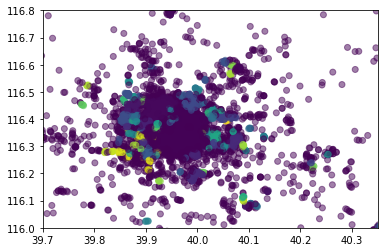

In [15]:
from sklearn.cluster import DBSCAN

#we are usign DBSCAN to cluster the centroids in order to compare the visiting patterns.

X=centroid_clusters[['lat','lng']].to_numpy()
db = DBSCAN(eps=20/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(X))

cluster_city = db.fit_predict(X)

plt.scatter(centroid_clusters['lat'],centroid_clusters['lng'], c=cluster_city,alpha=0.5 )
plt.xlim(39.7,40.35)
plt.ylim(116,116.8)

In [16]:
centroid_clusters['cluster_city']=cluster_city
centorid_clusters=centroid_clusters[centroid_clusters.cluster_city>-1]
users_city_stops=centroid_clusters.groupby(['uid'])['cluster_city'].unique().to_dict()

In [17]:
users_stops=list(users_city_stops.keys())
similarity_matrix=np.zeros((len(users_stops),len(users_stops)))


for idX in range(0,len(users_stops)):
    for idY in range(0,idX):
        stop_u1=users_city_stops[users_stops[idX]]
        stop_u2=users_city_stops[users_stops[idY]]
        similarity_matrix[idX,idY]=len(set(stop_u1).intersection(stop_u2))
        similarity_matrix[idY,idX]=similarity_matrix[idX,idY]

Text(0, 0.5, 'Similarity index')

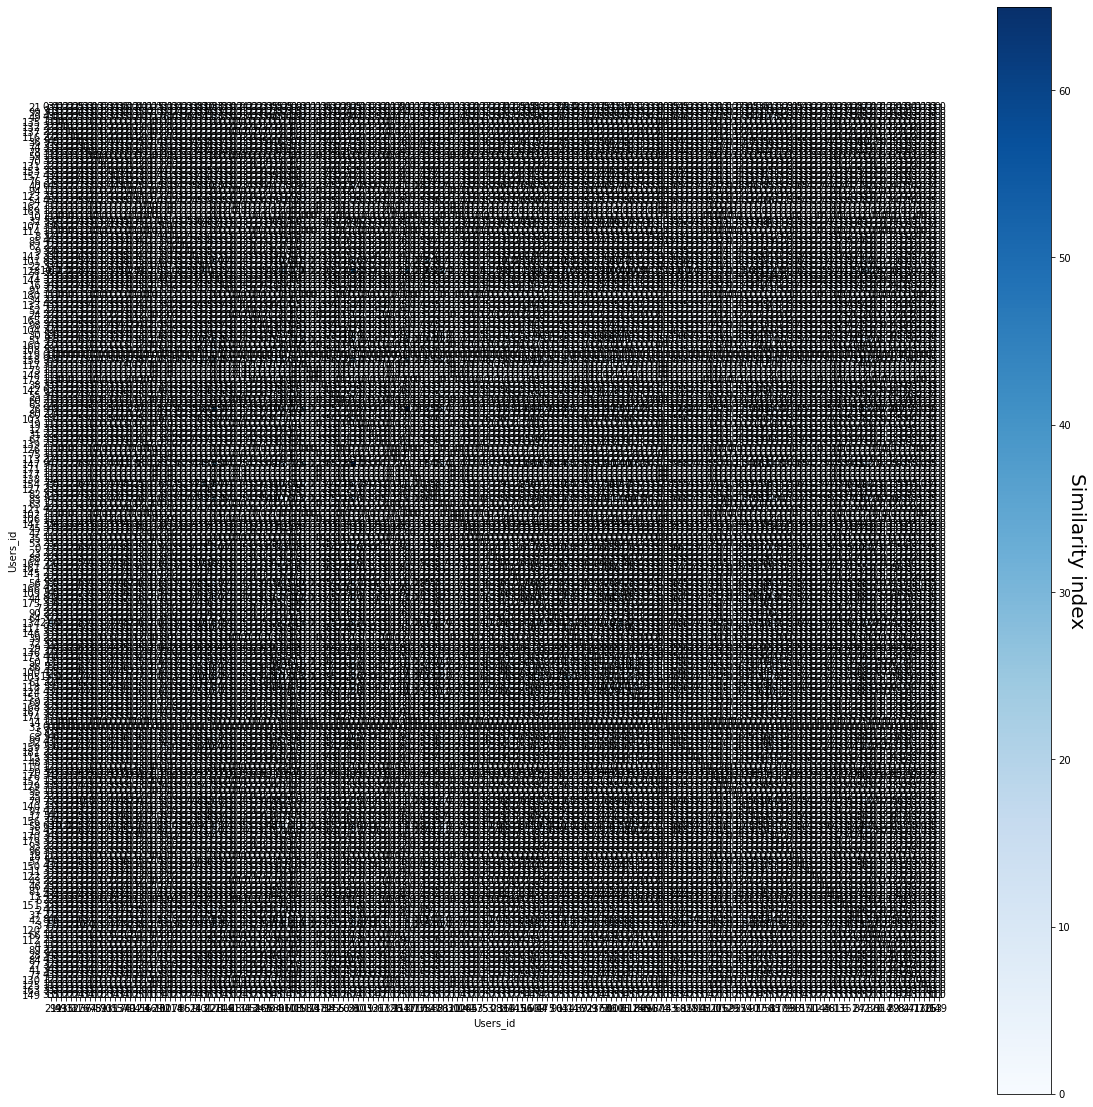

In [18]:
# A plot showing how similar the users movement pattern are will result from this
fig, ax = plt.subplots(figsize=(20,20))

min_val, max_val = 0, 15



map_sim=ax.matshow(similarity_matrix, cmap=plt.cm.Blues)

for i in range(len(users_stops)):
    for j in range(len(users_stops)):
        c = similarity_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
        
        

#Plots aesthetics.
user_id_label={str(k) for k in users_stops}
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax.set_xticks(range(0,len(users_stops)))
ax.set_xticklabels(user_id_label)
ax.set_yticks(range(0,len(users_stops)))
ax.set_yticklabels(user_id_label)
ax.set_xlabel('Users_id',fontsize=10)
ax.set_ylabel('Users_id',fontsize=10)
cbar=fig.colorbar(map_sim, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Similarity index', rotation=270,fontsize=20)

In [21]:
# It is clearly difficult to see the similarity between each user.
# This led to going through the analysis again.
# Thus, the users were ranked based on their number of stops and the top 20 users with most stops were analyzed

In [22]:
df = pd.read_csv('newGeolife.csv')

In [23]:
df.drop('Unnamed: 0', axis=1, inplace=True)
# tdf = skmob.TrajDataFrame(df, latitude='lat', longitude='lng', datetime = 'datetime')

In [24]:
df=df[(df['lat']<40.35) & (df['lat']>39.7)]
df=df[(df['lng']<116.8) & (df['lng']>116)]

In [25]:
df.head()

lat         lng             datetime uid
0  39.984683  116.318450  2008-10-23 02:53:10   0
1  39.984686  116.318417  2008-10-23 02:53:15   0
2  39.984688  116.318385  2008-10-23 02:53:20   0
3  39.984655  116.318263  2008-10-23 02:53:25   0
4  39.984611  116.318026  2008-10-23 02:53:30   0

In [26]:
df['value'] = 1

In [27]:
sdf = df.groupby(['uid'])['value'].count().to_frame().reset_index().sort_values(by='value', ascending=False).reset_index(drop = True)
# drop users that are not in the top 20
sdf = sdf[:20]
sdf

uid    value
0   153  1535578
1    17   946560
2    41   903483
3   128   901899
4    68   884877
5    85   582154
6    30   571326
7   163   514944
8   167   510215
9    65   419940
10    3   416800
11   22   412552
12   25   397277
13    4   392407
14   14   384049
15   52   330970
16  126   330559
17   50   313709
18   35   311968
19   84   304953

In [29]:
# create a list of the user id that are included in the users with the 20 most recorded points
uidList = list(set(sdf['uid']))
uidList
# remove all points that do not have a user id included in the top 20 users with the most recorded point
df = df[df.uid.isin(uidList)]

In [30]:
# use skmob to read the filtered dataframe
tdf = skmob.TrajDataFrame(df, latitude='lat', longitude='lng', datetime = 'datetime')

In [31]:
# Plot the mobility footprint of one of the users in the filtered dataframe
map_f = tdf.plot_trajectory(max_users=1, start_end_markers=False)
map_f

/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/skmob/utils/plot.py:133: UserWarning: Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  warnings.warn("Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.")
/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/skmob/utils/plot.py:158: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, sepecify `max_points=None`.
  warnings.warn("If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, sepecify `max_points=None`.")


In [32]:
#create stops where the users spent more than 20minutes and within a spatial_radius of 0.5km
stdf = detection.stops(tdf, stop_radius_factor=0.5, minutes_for_a_stop=20.0, spatial_radius_km=0.5, leaving_time=True)

# cluster these points together
cstdf = clustering.cluster(stdf)
cstdf.plot_stops(max_users=1, map_f=map_f)

/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/skmob/utils/plot.py:319: UserWarning: Only the stops of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  warnings.warn("Only the stops of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.")


(116.0, 116.8)

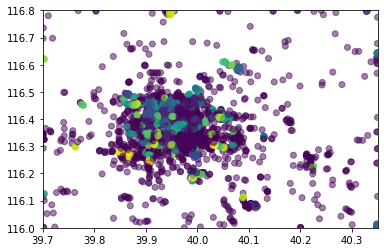

In [33]:
centroid_clusters=cstdf.groupby(['uid','cluster']).mean().reset_index()

from sklearn.cluster import DBSCAN

#DBSCAN is being used to cluster the centroids in order to compare the visiting patterns.

X=centroid_clusters[['lat','lng']].to_numpy()
db = DBSCAN(eps=20/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(X))

cluster_city = db.fit_predict(X)

plt.scatter(centroid_clusters['lat'],centroid_clusters['lng'], c=cluster_city,alpha=0.5 )
plt.xlim(39.7,40.35)
plt.ylim(116,116.8)

In [34]:
centroid_clusters['cluster_city']=cluster_city
centorid_clusters=centroid_clusters[centroid_clusters.cluster_city>-1]
users_city_stops=centroid_clusters.groupby(['uid'])['cluster_city'].unique().to_dict()

In [35]:
users_stops=list(users_city_stops.keys())
similarity_matrix=np.zeros((len(users_stops),len(users_stops)))


for idX in range(0,len(users_stops)):
    for idY in range(0,idX):
        stop_u1=users_city_stops[users_stops[idX]]
        stop_u2=users_city_stops[users_stops[idY]]
        similarity_matrix[idX,idY]=len(set(stop_u1).intersection(stop_u2))
        similarity_matrix[idY,idX]=similarity_matrix[idX,idY]

Text(0, 0.5, 'Similarity index')

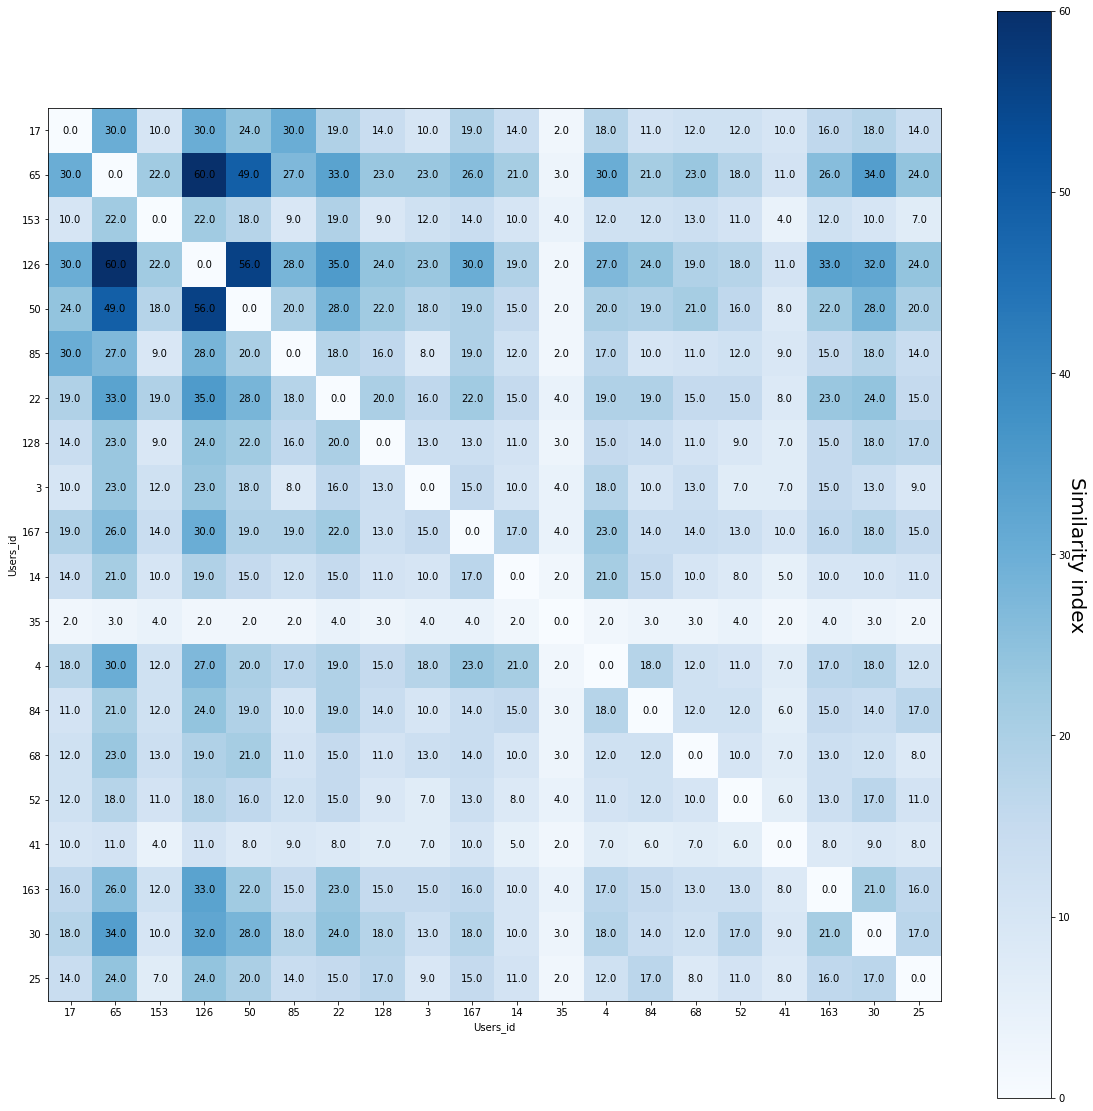

In [36]:
fig, ax = plt.subplots(figsize=(20,20))

min_val, max_val = 0, 15



map_sim=ax.matshow(similarity_matrix, cmap=plt.cm.Blues)

for i in range(len(users_stops)):
    for j in range(len(users_stops)):
        c = similarity_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
        
        

#Plots aesthetics.
user_id_label={str(k) for k in users_stops}
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax.set_xticks(range(0,len(users_stops)))
ax.set_xticklabels(user_id_label)
ax.set_yticks(range(0,len(users_stops)))
ax.set_yticklabels(user_id_label)
ax.set_xlabel('Users_id',fontsize=10)
ax.set_ylabel('Users_id',fontsize=10)
cbar=fig.colorbar(map_sim, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Similarity index', rotation=270,fontsize=20)

In [37]:
# The graph-like image above shows how similar the 20 users with most stops are